## Recipe  45 - Capping

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from feature_engine.outliers import Winsorizer

# from feature_engine.outlier_removers import Winsorizer

In [3]:
# boston.csv in local file 
boston = pd.read_csv('boston.csv')
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [5]:
def find_normal_boundaries(df, variable, distance):

    # calculate the boundaries outside which sit the outliers
    # for a Gaussian distribution

    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()

    return upper_boundary, lower_boundary

In [6]:
# find limits for RM

RM_upper_limit, RM_lower_limit = find_normal_boundaries(boston, 'RM', 3)
RM_upper_limit, RM_lower_limit

(8.392485817597748, 4.176782957105809)

In [7]:
# limits for LSTAT

LSTAT_upper_limit, LSTAT_lower_limit = find_normal_boundaries(boston, 'LSTAT', 3)
LSTAT_upper_limit, LSTAT_lower_limit

(34.07624777515244, -8.770121292938992)

In [8]:
# limits for CRIM

CRIM_upper_limit, CRIM_lower_limit = find_normal_boundaries(boston, 'CRIM', 3)
CRIM_upper_limit, CRIM_lower_limit

(29.41815887330972, -22.19111175868521)

In [9]:
# Now let's replace the outliers by the maximum and minimum limit

boston['RM']= np.where(boston['RM'] > RM_upper_limit, RM_upper_limit,
                       np.where(boston['RM'] < RM_lower_limit, RM_lower_limit, boston['RM']))

In [10]:
# Now let's replace the outliers by the maximum and minimum limit

boston['LSTAT']= np.where(boston['LSTAT'] > LSTAT_upper_limit, LSTAT_upper_limit,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, LSTAT_lower_limit, boston['LSTAT']))

In [11]:
# Now let's replace the outliers by the maximum and minimum limit

boston['CRIM']= np.where(boston['CRIM'] > CRIM_upper_limit, CRIM_upper_limit,
                       np.where(boston['CRIM'] < CRIM_lower_limit, CRIM_lower_limit, boston['CRIM']))

## Censoring with feature engine 

In [12]:
# boston.csv in local file 
boston = pd.read_csv('boston.csv')
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [13]:
# create the capper

windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RM', 'LSTAT', 'CRIM'])

windsorizer.fit(boston)

Winsorizer(tail='both', variables=['RM', 'LSTAT', 'CRIM'])

In [14]:
boston_t = windsorizer.transform(boston)

In [15]:
# we can inspect the minimum caps for each variable
windsorizer.left_tail_caps_

{'RM': 4.176782957105809,
 'LSTAT': -8.770121292938992,
 'CRIM': -22.19111175868521}

In [16]:
# we can inspect the maximum caps for each variable
windsorizer.right_tail_caps_

{'RM': 8.392485817597748,
 'LSTAT': 34.07624777515244,
 'CRIM': 29.41815887330972}

## Recipe 46 - Zero  coding 

In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from feature_engine.outliers import ArbitraryOutlierCapper


In [18]:
# let's create a data frame with a normal distributed variable x

np.random.seed(29) # for reproducibility

n = 200 # in the book we pass directly 200 within brackets, without defining n
x = np.random.randn(n) + 2
y = np.random.randn(n) * 2 + 4
z = np.random.randn(n) * 5 + 10

data = pd.DataFrame([x, y, z]).T
data.columns = ['x', 'y', 'z']

data.head()

,x,y,z
0,1.582518,6.903260,9.695655
1,2.706032,4.930279,14.363733
2,3.915985,4.688840,15.803355
3,-0.141755,3.488652,17.403682
4,2.719057,2.388501,20.859069


In [19]:
data.min()

x   -1.505401
y   -0.901451
z   -1.552986
dtype: float64

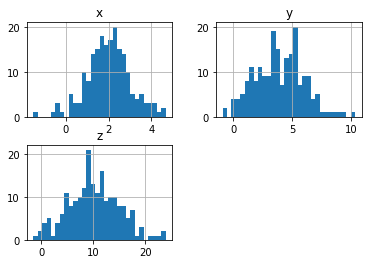

In [20]:
data.hist(bins=30)
plt.show()

In [21]:
data.loc[data['x'] < 0, 'x'] = 0
data.loc[data['y'] < 0, 'y'] = 0
data.loc[data['z'] < 0, 'z'] = 0

data.min()

x    0.0
y    0.0
z    0.0
dtype: float64

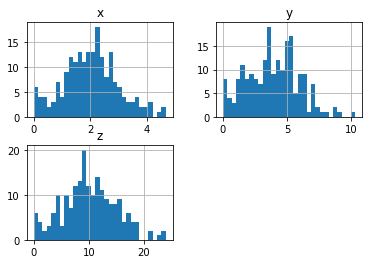

In [22]:
data.hist(bins=30)
plt.show()

## Zero coding with feature-engine

In [23]:
# let's create a data frame with a normal distributed variable x

np.random.seed(29) # for reproducibility

n = 200 # in the book we pass directly 200 within brackets, without defining n
x = np.random.randn(n) + 2
y = np.random.randn(n) * 2 + 4
z = np.random.randn(n) * 5 + 10

data = pd.DataFrame([x, y, z]).T
data.columns = ['x', 'y', 'z']

data.head()

,x,y,z
0,1.582518,6.903260,9.695655
1,2.706032,4.930279,14.363733
2,3.915985,4.688840,15.803355
3,-0.141755,3.488652,17.403682
4,2.719057,2.388501,20.859069


In [24]:
# create the capper

windsoriser = ArbitraryOutlierCapper(max_capping_dict=None,
                                     min_capping_dict={'x':0, 'y':0, 'z':0})

windsoriser.fit(data)

ArbitraryOutlierCapper(min_capping_dict={'x': 0, 'y': 0, 'z': 0})

In [25]:
data_t = windsoriser.transform(data)

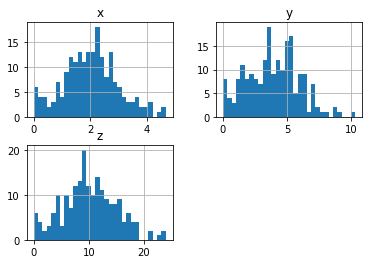

In [26]:
data_t.hist(bins=30)
plt.show()

In [27]:
# we can inspect the minimum caps for each variable
windsoriser.left_tail_caps_

{'x': 0, 'y': 0, 'z': 0}

In [28]:
# we can inspect the maximum caps for each variable
windsoriser.right_tail_caps_

{}

## Recipe 47 - Date Time features 

In [29]:
# let's create a toy dataframe with some date variables

# first we create a series with the ranges
rng_ = pd.date_range('2019-03-05', periods=20, freq='T')

# now we convert the series in a dataframe
df = pd.DataFrame({'date': rng_}) 

# output the first 5 rows
df.head()

,date
0,2019-03-05 00:00:00
1,2019-03-05 00:01:00
2,2019-03-05 00:02:00
3,2019-03-05 00:03:00
4,2019-03-05 00:04:00


In [30]:
# let's explore the variable type

df.dtypes

date    datetime64[ns]
dtype: object

In [31]:
# let's extract the date part

df['date_part'] = df['date'].dt.date

df['date_part'].head()

0    2019-03-05
1    2019-03-05
2    2019-03-05
3    2019-03-05
4    2019-03-05
Name: date_part, dtype: object

In [32]:
# let's create a toy dataframe where the datetime variable is cast
# as object

df = pd.DataFrame({'date_var':['Jan-2015', 'Apr-2013', 'Jun-2014', 'Jan-2015']})
df

,date_var
0,Jan-2015
1,Apr-2013
2,Jun-2014
3,Jan-2015


In [34]:
# let's explore the variable type

df.dtypes

date_var    object
dtype: object

In [35]:
# let's re-cast the variable as datetime

df['datetime_var'] = pd.to_datetime(df['date_var'])
df

,date_var,datetime_var
0,Jan-2015,2015-01-01
1,Apr-2013,2013-04-01
2,Jun-2014,2014-06-01
3,Jan-2015,2015-01-01


In [36]:
# let's extract date and time

df['date'] = df['datetime_var'].dt.date
df['time'] = df['datetime_var'].dt.time

df

,date_var,datetime_var,date,time
0,Jan-2015,2015-01-01,2015-01-01,00:00:00
1,Apr-2013,2013-04-01,2013-04-01,00:00:00
2,Jun-2014,2014-06-01,2014-06-01,00:00:00
3,Jan-2015,2015-01-01,2015-01-01,00:00:00


In [37]:
# let's explore the variable types

df.dtypes

date_var                object
datetime_var    datetime64[ns]
date                    object
time                    object
dtype: object

## Recipe 48  - year - month - semester 

In [39]:
# let's create a toy dataframe with a date variable which values
# increase 1 month at a time

rng_ = pd.date_range('2019-03-05', periods=20, freq='M')
df = pd.DataFrame({'date': rng_}) 
df.head()

,date
0,2019-03-31
1,2019-04-30
2,2019-05-31
3,2019-06-30
4,2019-07-31


In [40]:
# extract year

df['year'] = df['date'].dt.year

df.head()

,date,year
0,2019-03-31,2019
1,2019-04-30,2019
2,2019-05-31,2019
3,2019-06-30,2019
4,2019-07-31,2019


In [41]:
# extract month

df['month'] = df['date'].dt.month

df.head()

,date,year,month
0,2019-03-31,2019,3
1,2019-04-30,2019,4
2,2019-05-31,2019,5
3,2019-06-30,2019,6
4,2019-07-31,2019,7


In [42]:
# extract quarter

df['quarter'] = df['date'].dt.quarter

df.head()

,date,year,month,quarter
0,2019-03-31,2019,3,1
1,2019-04-30,2019,4,2
2,2019-05-31,2019,5,2
3,2019-06-30,2019,6,2
4,2019-07-31,2019,7,3


In [43]:
# extract semester

df['semester'] = np.where(df['quarter'].isin([1,2]), 1,2)

df.head()

,date,year,month,quarter,semester
0,2019-03-31,2019,3,1,1
1,2019-04-30,2019,4,2,1
2,2019-05-31,2019,5,2,1
3,2019-06-30,2019,6,2,1
4,2019-07-31,2019,7,3,2


## Recipe 49 - Represenations of week 

In [44]:
# let's create a toy dataframe with a date variables which values
# increase by 1 day

rng_ = pd.date_range('2019-03-05', periods=20, freq='D')
df = pd.DataFrame({'date': rng_}) 
df.head() 

,date
0,2019-03-05
1,2019-03-06
2,2019-03-07
3,2019-03-08
4,2019-03-09


In [45]:
# extract day of the month - with possible values 1 to 31

df['day_mo'] = df['date'].dt.day

df.head()

,date,day_mo
0,2019-03-05,5
1,2019-03-06,6
2,2019-03-07,7
3,2019-03-08,8
4,2019-03-09,9


In [46]:
# extract day of the week - with possible values 0-6

df['day_week'] = df['date'].dt.dayofweek

df.head()

,date,day_mo,day_week
0,2019-03-05,5,1
1,2019-03-06,6,2
2,2019-03-07,7,3
3,2019-03-08,8,4
4,2019-03-09,9,5


In [47]:
df['day_week'].unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int64)

In [50]:
# extract name of day of the week 

# df['day_week_name'] = df['date'].dt.weekday_name

df['day_week_name'] = df['date'].dt.day_name()

df.head()

,date,day_mo,day_week,day_week_name
0,2019-03-05,5,1,Tuesday
1,2019-03-06,6,2,Wednesday
2,2019-03-07,7,3,Thursday
3,2019-03-08,8,4,Friday
4,2019-03-09,9,5,Saturday


In [51]:
# is it weekend?

df['is_weekend'] = np.where(df['day_week_name'].isin(['Sunday', 'Saturday']), 1,0)

df.head()

,date,day_mo,day_week,day_week_name,is_weekend
0,2019-03-05,5,1,Tuesday,0
1,2019-03-06,6,2,Wednesday,0
2,2019-03-07,7,3,Thursday,0
3,2019-03-08,8,4,Friday,0
4,2019-03-09,9,5,Saturday,1


In [52]:
# Extract week of year from date, with possible values from 1 to 52

df['week'] = df['date'].dt.week

df.head()

C:\Users\Arindam Banerji\AppData\Local\Temp\ipykernel_6264\2580913015.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['date'].dt.week


,date,day_mo,day_week,day_week_name,is_weekend,week
0,2019-03-05,5,1,Tuesday,0,10
1,2019-03-06,6,2,Wednesday,0,10
2,2019-03-07,7,3,Thursday,0,10
3,2019-03-08,8,4,Friday,0,10
4,2019-03-09,9,5,Saturday,1,10
